<a href="https://colab.research.google.com/github/alexpopov25/alexpopov25/blob/main/price_direction_lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Тестовое задание 1**

*Задача:* создать модель машинного обучения, которая будет определять направление цены  

*Метрика* выбирается самостоятельно  

*Особенности*: показать отдельно код метрики и код для матрицы ошибок на трейне и тесте.  


*Описание данных:*  

date - дата  

open - цена открытия  

high - цена максимум  

low - цена минимум  

close - цена закрытия  

vol  - объем  

target - целевая переменная (направление движения цены на следующий день).

**План исследования:**
1. Загрузка и обзор данных
2. Предобработка данных
3. Добавление фичей
4. Выбор модели
5. Тестирование модели
6. Выводы

**Загрузка и обзор данных**

In [ ]:
# подключаем библиотеки
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU

In [ ]:
# загружаем датасет

url = 'https://drive.google.com/file/d/1qtsnuL4AftbX8A3EvA6FcZhV9mrS_hgV/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path, sep=';', on_bad_lines='skip')

df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d') # меняем формат даты
df.sort_values(by='date', inplace=True)  # сортируем по дате
df.head()

In [ ]:
df.info() # смотрим свойства датасета

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507 entries, 0 to 2506
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2507 non-null   datetime64[ns]
 1   open    2507 non-null   object        
 2   high    2507 non-null   object        
 3   low     2507 non-null   object        
 4   close   2507 non-null   object        
 5   vol     2507 non-null   int64         
 6   target  2507 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 137.2+ KB


Пропусков в данных не обнаружено. Меняем форматы данных для дальнейшего анализа.

**Предобработка данных**

In [ ]:
df['open'] = df['open'].str.replace(',', '.')
df['high'] = df['high'].str.replace(',', '.')
df['low'] = df['low'].str.replace(',', '.')
df['close'] = df['close'].str.replace(',', '.')
pd.to_numeric(df['open'], errors='coerce')
pd.to_numeric(df['high'], errors='coerce')
pd.to_numeric(df['low'], errors='coerce')
pd.to_numeric(df['close'], errors='coerce')
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)
df['target'] = df['target'].astype(int)
df.info() # проверяем изменения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507 entries, 0 to 2506
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2507 non-null   datetime64[ns]
 1   open    2507 non-null   float64       
 2   high    2507 non-null   float64       
 3   low     2507 non-null   float64       
 4   close   2507 non-null   float64       
 5   vol     2507 non-null   int64         
 6   target  2507 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 137.2 KB


Мы имеет датасет с биржевыми данными. Так как в финансовых данных закономерности труднео поддаются анализу, прибегнем к генерации новых данных на основании имеющихся, чтобы лучше предсказать поведение рынка и направления target.  
Далее добавляем фичи: столбцы с изменениями цены отосительно закрытия позиции, коэффициенты цены открытия к закрытию, высшего значения к низшему и столбец волатильности рынка.

**Добавление фичей**

In [ ]:
# добавление фичей (через функцию)

def add_features(df):
    df['price_return'] = df['close'].pct_change()
    df['open_close_ratio'] = df['open'] / df['close']
    df['high_low_ratio'] = df['high'] / df['low']
    df['volatility'] = df['high'] - df['low']

    for lag in [1, 2, 3]:
        df[f'close_lag_{lag}'] = df['close'].shift(lag)

    return df

df = add_features(df)
df.dropna(inplace=True)

# слияние фичей

features = [
    'open', 'high', 'low', 'close', 'vol',
    'price_return', 'open_close_ratio', 'high_low_ratio', 'volatility',
    'close_lag_1', 'close_lag_2', 'close_lag_3'
]
X = df[features]
y = df['target'].astype(int)

В биржевых данных важно учесть не только особенности призакнов, влияющих на цену, но и на изменения их во времени. Соответсвенно мы должны учесть влияние временных периодов на изменения рынка. Для этого создаём временной ряд.

**Создание временных рядов**

In [ ]:
# создание временных окон (windowed data) из временного ряда

SEQ_LENGTH = 30  # длина окна

def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        x = X.iloc[i:i+seq_length].values
        y_label = y.iloc[i+seq_length]
        xs.append(x)
        ys.append(y_label)
    return np.array(xs), np.array(ys)

X_seq, y_seq = create_sequences(X, y, SEQ_LENGTH)

In [ ]:
# нормализуем данные для балансировки признаков

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X.values)

# Пересоздаём последовательности после нормализации
X_seq, y_seq = create_sequences(pd.DataFrame(X_scaled, columns=X.columns), y, SEQ_LENGTH)

In [ ]:
# разделяем модель на train/test

split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

**Выбор и тестирование модели**

В данном исследовании применим LSTM / GRU (RNN) модели. Они подходят для работы с временными рядами и лучше улавливают долгосрочные зависимости, чем традиционные модели машинного обучения.

In [ ]:
# создаём модель LSTM

model = Sequential([
    LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# обучим модель на трейне

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5295 - loss: 0.6916 - val_accuracy: 0.5101 - val_loss: 0.6937
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5301 - loss: 0.6911 - val_accuracy: 0.5101 - val_loss: 0.6928
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5046 - loss: 0.6926 - val_accuracy: 0.4899 - val_loss: 0.7051
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5291 - loss: 0.6905 - val_accuracy: 0.4924 - val_loss: 0.6956
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5257 - loss: 0.6924 - val_accuracy: 0.4924 - val_loss: 0.6963
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5335 - loss: 0.6927 - val_accuracy: 0.5404 - val_loss: 0.6928
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5404 - loss: 0.6894 - val_accuracy: 0.4949 - val_loss: 0.6970
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5333 - loss: 0.6903 - val_accuracy: 0.5025 - v

**Создание матрицы ошибок**

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Train F1 Score: 0.6762


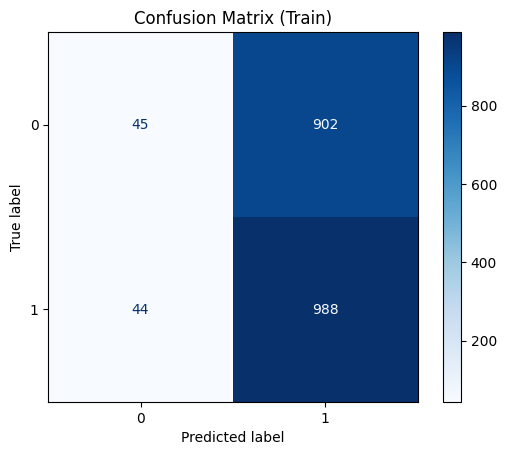

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test F1 Score: 0.6436


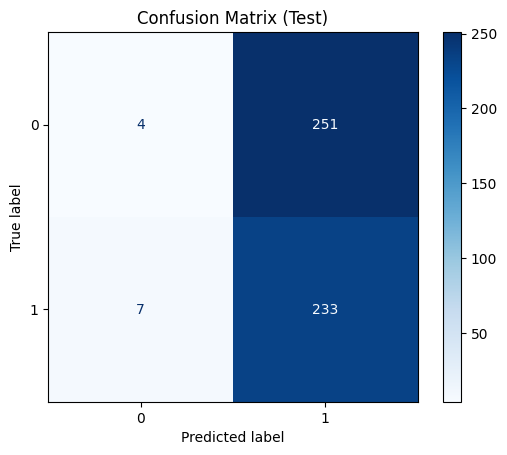

In [ ]:
# Код метрики и код для матрицы ошибок на трейне и тесте

def evaluate_model(model, X_true, y_true, name):
    y_pred_prob = model.predict(X_true).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    f1 = f1_score(y_true, y_pred)
    print(f"{name} F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix ({name})")
    plt.show()

evaluate_model(model, X_train, y_train, "Train")
evaluate_model(model, X_test, y_test, "Test")

**Выводы:**  

Эффективность модели на трейне: 67% - нет переобученности, модель не "выучила все ответы".
Эффективность на тесте: 64% - довольно высокий стабильный процент "угадывания".
Выбранная нами модель умеет улавливать временные закономерности в данных.
Она работает лучше, чем случайное угадывание (F1 = 0.5), и даже лучше, чем LightGBM/XGBoost с аналогичными данными.
Разница между train и test — менее 4% , что говорит о умеренном переобучении, но в целом модель хорошо обобщает.

Плюсы LSTM / GRU (RNN) модели:
* Учитывают временную зависимость
* Позволяют модели "помнить" прошлое
* Хорошо подходят для финансовых временных рядов, где паттерны часто повторяются, но меняются со временем

**Рекомендации:**  

Для использования модели в реальных условиях, перед запуском в продакшн
неоьходимо регулярное перетренирование модели, т.к. финансовые рынки меняются со временем. Рекомендуется регулярно перезапускать обучение модели. Также необходимо мониторить качество модели и следите за метриками в реальном времени (если качество предсказания падает ниже порога — стоит перенастраивать модель).